In [1]:
import csv
import cv2
import numpy as np
import sklearn

In [2]:
#Load data
#Convention used - data_folders is an array of folders containing a file named 'driving_log.csv' and an IMG folder with
#a simulation images in it. This correlated to the output of the simulator for this project. It makes it easy to add
#and remove simulations from the model.
data_folders = [ "./data/original_data/", "./data/track_1_lap_1_forward/",
                "./data/track_1_lap_1_backward/", "./data/track_1_turns_data/",
                "./data/track_1_turns_extra/", "./data/track_1_turns_extra1/",
                "./data/track_1_turns_extra2/", "./data/track_1_lap_2_forward/",
                "./data/track_1_turns_extra3/", "./data/track_1_lap_3_forward/"]
data_file_name = "driving_log.csv"

#Opening up the driving_log.csv and reading all image paths into 'samples' array.
samples = []
for folder in data_folders:
    lines = []
    with open(folder + data_file_name) as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            samples.append(line)

#We split the data, still without loading it (just the paths) to training and validation sets.
from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

#Print sizes for sanity
print(len(samples), len(train_samples), len(validation_samples))


17372 13897 3475


In [3]:
from sklearn.utils import shuffle
#Create a generator function which yields the images into memory upon need in batches.
#The generator does: 1) Shuffle the data 2)Read the image 3) add augmented image per image loaded to the set
#The generator returns training and validation set updates with current batch samples.
def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                #Calculate name properly, the first 'if' deals with a relative path beginning with 'IMG' in the csv
                #The 'else' clause deals with an absolute path in the 'csv'
                #We assume everything is under 'data' folder relative to current location.
                name = "./data"
                if (batch_sample[0].startswith("IMG")):
                    name += "/original_data" 
                else: 
                    name += "/" + batch_sample[0].split('/')[-3]
                    
                name += '/IMG/'+ batch_sample[0].split('/')[-1]
                
                #print(name)
                #Read image and angle
                center_image = cv2.imread(name)
                center_angle = float(batch_sample[3])
                #Add image and angle
                images.append(center_image)
                angles.append(center_angle)
                #Add augmented version of them
                images.append(cv2.flip(center_image,1))
                angles.append(center_angle * -1.0)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)



In [4]:
ch, row, col = 3, 160, 320 

In [10]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Convolution2D, Dropout
#The model architecture, we're following the architecture as seen in class.
#Preprocessing: normalizing the values and cropping each image
#Regularization: using several dropout layers with 0.1 percent hyperparameter
#Architecture: 4Conv layers (with dropout between) followed by 4 FC layers
model = Sequential()
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(row, col, ch),
        output_shape=(row, col, ch)))
model.add(Cropping2D(cropping=((70,25),(0,0))))
model.add(Convolution2D(24,5,5, subsample=(2,2), activation="relu"))
model.add(Dropout(0.1))
model.add(Convolution2D(36,5,5, subsample=(2,2), activation="relu"))
model.add(Dropout(0.1))
model.add(Convolution2D(48,5,5, subsample=(2,2), activation="relu"))
model.add(Dropout(0.1))
model.add(Convolution2D(64,3,3, activation="relu"))
model.add(Convolution2D(64,3,3, activation="relu"))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

#Defining the loss function as mse (as we're doing regression) and using 'adam' optimizer 
model.compile(loss='mse', optimizer='adam')
#Fitting the model, using 4 epochs and generator for efficiency purposes.
history_object = model.fit_generator(train_generator, samples_per_epoch= len(train_samples), verbose=1,
                    validation_data=validation_generator, nb_val_samples=len(validation_samples), nb_epoch=4)

#Saving the model
model.save('model.h5')

Epoch 1/4
13842/13897 [============================>.] - ETA: 0s - loss: 0.0280

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


13906/13897 [==============================] - 32s - loss: 0.0279 - val_loss: 0.0252
Epoch 2/4
13952/13897 [==============================] - 32s - loss: 0.0259 - val_loss: 0.0285
Epoch 3/4
13906/13897 [==============================] - 32s - loss: 0.0237 - val_loss: 0.0231
Epoch 4/4
13952/13897 [==============================] - 32s - loss: 0.0248 - val_loss: 0.0230


dict_keys(['loss', 'val_loss'])


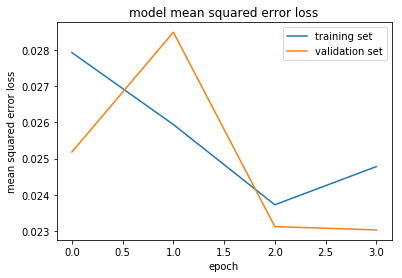

In [11]:
import matplotlib.pyplot as plt

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()